# Web Scraping the SEC Query Page + Text Mining the Filings
Joseph Obonyo  
Source code from: [Sigma Coding](https://github.com/josephobonyo/sigma_coding_youtube/tree/master/python/python-finance/sec-web-scraping) + expanded code

In [1]:
# import our libraries
import requests
import pandas as pd
from bs4 import BeautifulSoup

### SEC CIK Number Search

In [175]:
# base URL for the SEC EDGAR browser
endpoint = r"https://www.sec.gov/cgi-bin/browse-edgar"

# define our parameters dictionary
param_dict = {'action':'getcompany',
              'owner':'exclude',
              'company':'general motors'}  # Replace the company value with the name of the company to be searched

# request the url, and then parse the response.
response = requests.get(url = endpoint, params = param_dict)
soup = BeautifulSoup(response.content, 'html.parser')

# Let the user know it was successful.
print('Request Successful')
# The link takes you to the page with the results of the search
print(response.url)

Request Successful
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&owner=exclude&company=general+motors


### Filing Search

In [223]:
# base URL for the SEC EDGAR browser
endpoint = r"https://www.sec.gov/cgi-bin/browse-edgar"

# define our parameters dictionary
param_dict = {'action':'getcompany',
              'CIK':'0001326801',  # Enter CIK number for specific search
              'type':'S-1',        # Enter desired filing
              'dateb':'20211120',  # Date before
              'owner':'exclude',
              'start':'',
              'output':'',
              'count':'5'}         # Minimum count is 10 by default

# request the url, and then parse the response. SEC requires that you identify yourself with an email address, otherwise
# you'll be identified as a bot
headers = {"User-Agent": "My-User_Agent", 'From': 'jobonyo@drew.edu'}
response = requests.get(url = endpoint, params = param_dict, headers=headers)  
soup = BeautifulSoup(response.content, 'html.parser')

# Let the user know it was successful.
print('Request Successful')
print(response.url)

Request Successful
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=0001326801&type=S-1&dateb=20211120&owner=exclude&start=&output=&count=5


In [224]:
# find the document table with our data
doc_table = soup.find_all('table', class_='tableFile2')

# define a base url that will be used for link building.
base_url_sec = r"https://www.sec.gov"

master_list = []

# define function to get the link to the filing in a specific year from the filing_doc_link
def get_filing_link(filing_doc_link):
    # make request using user-agent to the filings page
    headers = {"User-Agent": "My-User_Agent", 'From': 'jobonyo@drew.edu'}
    response = requests.get(url = filing_doc_link, headers=headers) 
    soup = BeautifulSoup(response.content, 'html.parser')

    table = soup.find_all('table', class_='tableFile')
    href = table[0].find_all('a')[0].get('href')
    filing_link = base_url_sec + href
    
    return filing_link
    

# loop through each row in the table.
for row in doc_table[0].find_all('tr'):
    
    # find all the columns
    cols = row.find_all('td')
    
    # if there are no columns move on to the next row.
    if len(cols) != 0:        
        
        # grab the text
        filing_type = cols[0].text.strip()                 
        filing_date = cols[3].text.strip()
        filing_numb = cols[4].text.strip()
        
        # find the links
        filing_doc_href = cols[1].find('a', {'href':True, 'id':'documentsbutton'})       
        filing_int_href = cols[1].find('a', {'href':True, 'id':'interactiveDataBtn'})
        filing_num_href = cols[4].find('a')
        
        # grab the the first href
        if filing_doc_href != None:
            filing_doc_link = base_url_sec + filing_doc_href['href'] 
        else:
            filing_doc_link = 'no link'
        
        # grab the second href
        if filing_int_href != None:
            filing_int_link = base_url_sec + filing_int_href['href'] 
        else:
            filing_int_link = 'no link'
        
        # grab the third href
        if filing_num_href != None:
            filing_num_link = base_url_sec + filing_num_href['href'] 
        else:
            filing_num_link = 'no link'
        
        # call function to get the filing link for this year in the loop
        filing_link = get_filing_link(filing_doc_link)
        
        # create and store data in the dictionary
        file_dict = {}
        file_dict['file_type'] = filing_type
        file_dict['file_number'] = filing_numb
        file_dict['file_date'] = filing_date
        file_dict['links'] = {}
        file_dict['links']['documents'] = filing_doc_link
        file_dict['links']['interactive_data'] = filing_int_link
        file_dict['links']['filing_number'] = filing_num_link
        file_dict['links']['filing_link'] = filing_link
    
        # let the user know it's working
        print('-'*100)        
        print("Filing Type: " + filing_type)
        print("Filing Date: " + filing_date)
        print("Filing Number: " + filing_numb)
        print("Document Link: " + filing_doc_link)
        print("Filing Number Link: " + filing_num_link)
        print("Interactive Data Link: " + filing_int_link)
        print("Link to HTML File: " + filing_link)
        
        # append dictionary to master list
        master_list.append(file_dict)

----------------------------------------------------------------------------------------------------
Filing Type: S-1/A
Filing Date: 2012-05-16
Filing Number: 333-17928712847255
Document Link: https://www.sec.gov/Archives/edgar/data/1326801/000119312512235588/0001193125-12-235588-index.htm
Filing Number Link: https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&filenum=333-179287&owner=exclude&count=10
Interactive Data Link: no link
Link to HTML File: https://www.sec.gov/Archives/edgar/data/1326801/000119312512235588/d287954ds1a.htm
----------------------------------------------------------------------------------------------------
Filing Type: S-1/A
Filing Date: 2012-05-15
Filing Number: 333-17928712840860
Document Link: https://www.sec.gov/Archives/edgar/data/1326801/000119312512232582/0001193125-12-232582-index.htm
Filing Number Link: https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&filenum=333-179287&owner=exclude&count=10
Interactive Data Link: no link
Link to HTML

## Extracting All Words From Filing
Simplest way to parse the filings is to copy the link to the html file into the url keyword argument.

In [225]:
# Requesting data from SEC. Use desired html file link
headers = {"User-Agent": "My-User_Agent", 'From': 'jobonyo@drew.edu'}
response = requests.get(url = r'https://www.sec.gov/Archives/edgar/data/1326801/000119312512034517/d287954ds1.htm', headers=headers) 
soup = BeautifulSoup(response.content, 'html.parser')

In [226]:
# Collecting text from the filing using each 'div' element in html as an element in the list
text = [soup.find_all('div')[i].get_text() for i in range(len(soup.find_all('div')))]

In [227]:
# Converting elements in the list to a dataframe
text_df = pd.DataFrame(data=text, columns=['filing_body'])

In [228]:
text_df['filing_body']

0     \n\n\n\n\n\n\n\n\n \n  \nPage\n \n\n Prospectu...
1     \n\n\n\n\n\n\n\n\n \n  \nPage\n \n\n Managemen...
2                                                      
3     \nPROSPECTUS SUMMARY \n  This summary highligh...
4     \nPROSPECTUS SUMMARY \n  This summary highligh...
5     \nFor a description of how we calculate our MA...
6     \nFor a description of how we calculate our MA...
7     \nHow We Create Value for Developers Through t...
8     \nHow We Create Value for Developers Through t...
9     \n\nintent. According to an industry source, t...
10    \n\nintent. According to an industry source, t...
11    \n\n\n \n \nWe continue to invest in tools and...
12    \n\n\n \n \nWe continue to invest in tools and...
13    \n\n\n \n•\n \n Substantial blocks of our tota...
14    \n\n\n \n•\n \n Substantial blocks of our tota...
15    \nTHE OFFERING \n  Class A common stock offere...
16    \nTHE OFFERING \n  Class A common stock offere...
17    \n\n\n Voting rights \n Shares of Class A 

Text is filled with special characters. These will be cleaned to get close to individual words.

## Cleaning List of Words

In [82]:
import spacy
import re
import numpy as np

In [83]:
nlp = spacy.blank('en')

In [84]:
# Removing characters that don't add anything to the data
other_chars = ['*', '#', '&x200B', '[', ']', '; ', ":",' ;' "&nbsp", "“","“","”", "\u200b", "xa0", "\xa0", "\n", "/s/", 
               "-", "☐", "☒", "(", ")", "$", "_", "%", ",", ".", "\u2009", "\u2007"]
def remove_other_chars(x: str):
    for char in other_chars:
        x = x.replace(char, ' ')
    
    return x

# Strip the white space on both sides of each string
strip = lambda x : x.strip()

# Removing stop words (such as punctuations) using natural language processing from spacy
def remove_stop_words(text):
    doc = nlp(text)
    return " ".join([token.text for token in doc if not token.is_stop])

# Make all text lower case
lower_case_text = lambda x: x.lower()

# Replace blanks with nan values to make it easier to drop those values
replace_blanks = lambda x: x.replace('', np.nan)

# Drops the nan values
drop_blanks = lambda x: x.dropna()

In [229]:
# Looping through the list of functions to execute them 1 by 1
funcs = [remove_other_chars, strip, remove_stop_words, lower_case_text]

for fun in funcs:
    text_df['filing_body'] = text_df['filing_body'].apply(fun)

text_df['filing_body']= text_df['filing_body'].str.replace('\d+', '')

text_df = text_df.apply(replace_blanks)

text_df = text_df.apply(drop_blanks)

In [230]:
# Convert the pandas series to a list
text_list = list(text_df['filing_body'])

In [231]:
# Keep only the elements in the list with more than one character
text_list = [word for word in text_list if len(word) > 1]

At this point, we're close to having clean words though it won't be perfect. 

## Exploratory Data Analysis

In [89]:
from collections import Counter
from wordcloud import WordCloud, STOPWORDS
import seaborn as sns
import matplotlib.pyplot as plt

### Plotting Word Cloud

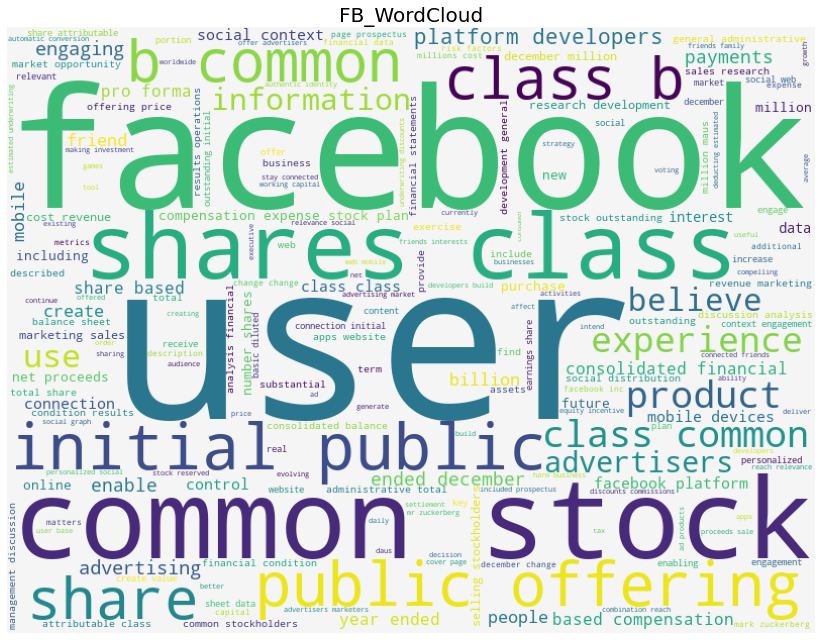

In [232]:
fig_wordcloud = WordCloud(stopwords=STOPWORDS, background_color='whitesmoke', 
                          colormap='viridis', width=800, height=600
                         ).generate(' '.join(text_list))

title = 'FB_WordCloud'
plt.figure(figsize=(12, 9), frameon=True)
plt.imshow(fig_wordcloud)
plt.axis('off')
plt.title(title, size=20)
plt.tight_layout()
plt.savefig(title + '.png', format='png', dpi=300)
plt.show()

### Plotting Unigrams
Meaning individual words

In [233]:
# Generate counter for n grams
counter = Counter()

for item in text_list:
    doc = nlp(item)
    counter.update([token.text for token in doc])

In [234]:
most_common_unigrams = counter.most_common()[0:30]
words = [item[0] for item in most_common_unigrams]
freq = [item[1] for item in most_common_unigrams]

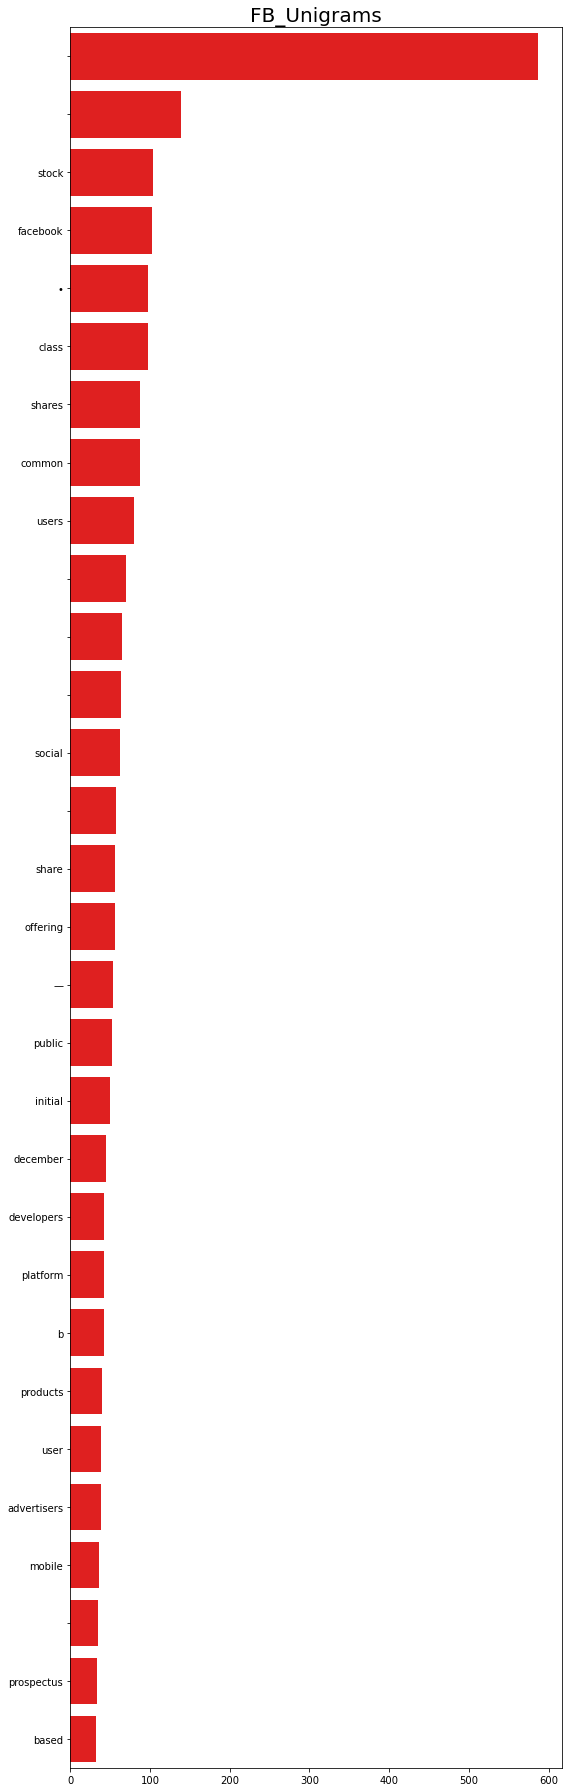

In [235]:
plt.figure(figsize=(8, 25))
sns.barplot(y=words, x=freq, color='red')
title = 'FB_Unigrams'
plt.title(title, size=20)
plt.tight_layout()
plt.savefig(title + '.png', format='png', dpi=300)

### Plotting Bigrams
Meaning sequence of two words

In [49]:
def generate_ngrams(text, n_gram=2):
    token = [token for token in text.lower().split(' ') if token != '']
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    return [' '.join(ngram) for ngram in ngrams]

In [236]:
# Generate counter for n grams
bigram_counter = Counter()

for body in text_list:
    bigram_counter.update(generate_ngrams(body, 2))

In [237]:
most_common_bigrams = bigram_counter.most_common()[0:30]
bigrams = [item[0] for item in most_common_bigrams]
bi_freq = [item[1] for item in most_common_bigrams]

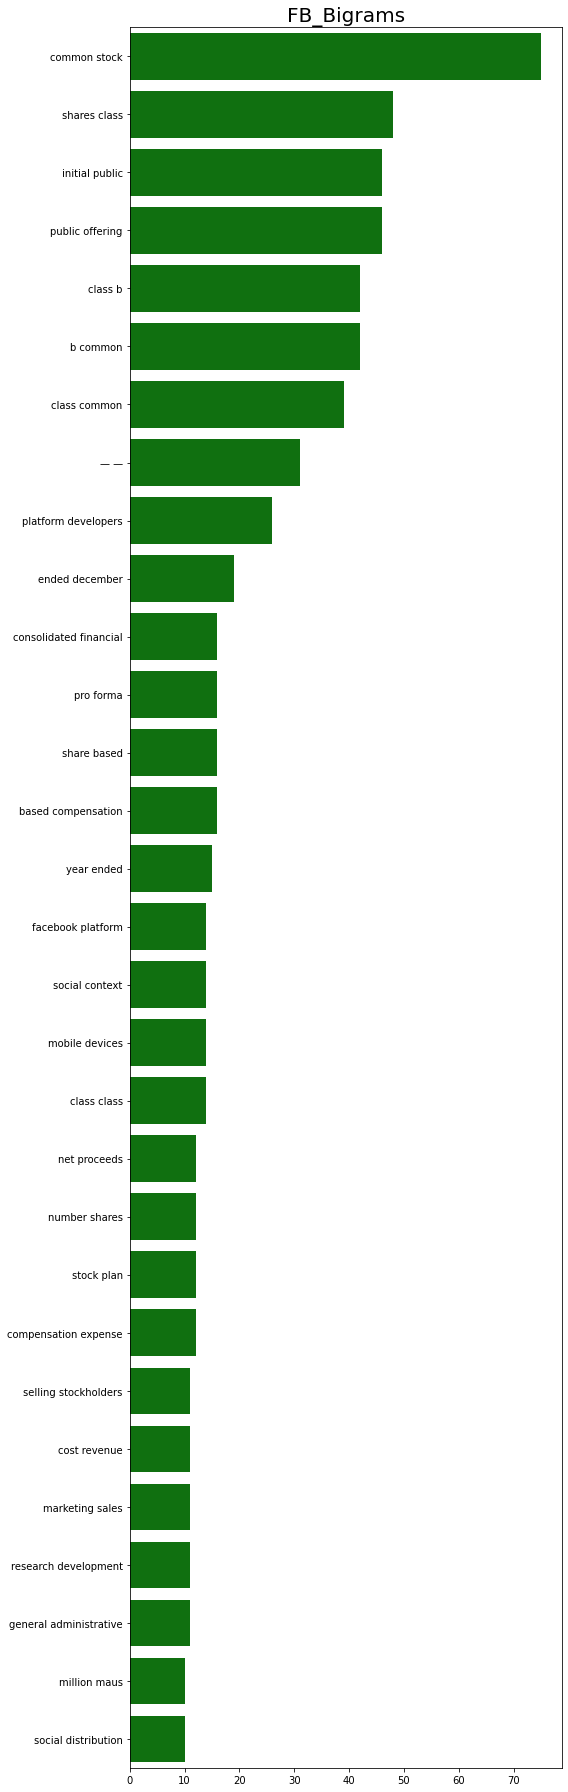

In [238]:
plt.figure(figsize=(8, 25))
sns.barplot(y=bigrams, x=bi_freq, color='green')
title = 'FB_Bigrams'
plt.title(title, size=20)
plt.tight_layout()
plt.savefig(title + '.png', format='png', dpi=300)

### Plotting Trigrams
Meaning sequence of 3 words

In [239]:
# Generate counter for n grams
trigram_counter = Counter()

for body in text_list:
    trigram_counter.update(generate_ngrams(body, 3))

In [240]:
most_common_trigrams = trigram_counter.most_common()[0:30]
trigrams = [item[0] for item in most_common_trigrams]
tri_freq = [item[1] for item in most_common_trigrams]

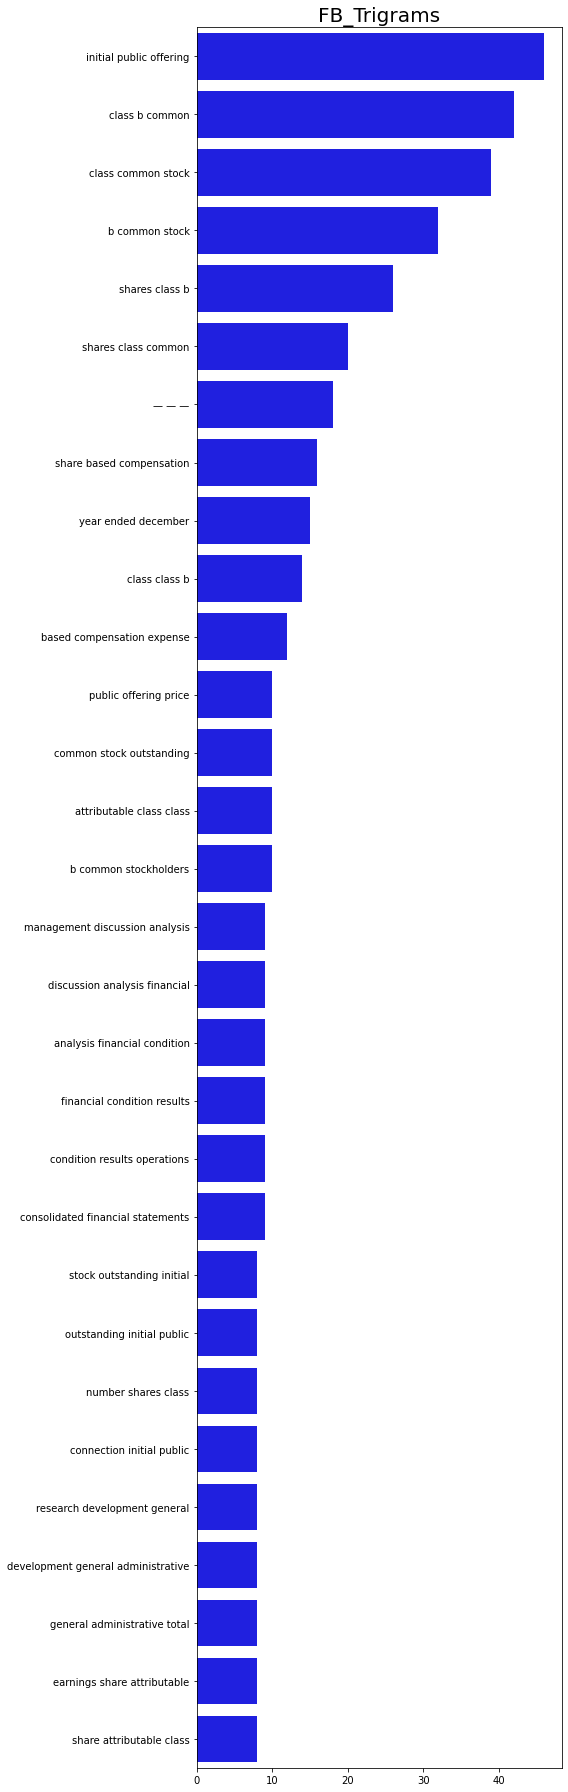

In [241]:
plt.figure(figsize=(8, 25))
sns.barplot(y=trigrams, x=tri_freq, color='blue')
title = 'FB_Trigrams'
plt.title(title, size=20)
plt.tight_layout()
plt.savefig(title + '.png', format='png', dpi=300)

### Conclusions
- There seems to be more insight to gain from the word cloud than the n-gram charts in the case of the S-1 filing
- In the example shown, Facebooks IPO had a lot of emphasis on advertising revenue and information, in addition to all the mentions of social networks. This started to really manifest itself year's later.
- The n-gram charts give us information that is found on every company's filing